In [1]:
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt
from neuron import h

%load_ext autoreload
%autoreload 2

from GrC import GrC

In [2]:
# Instantiation of the cell templates
cells = [GrC(1, "regular"), GrC(1, "mild"), GrC(1, "adapting"), GrC(1, "accelerate")]

# Fixed time step only
time_step = h.CVode()
time_step.active(0)  # 0 fixed step, 1 variable time step

# Activate the multisplit to use half of cores available (with a max of 8)
cpu = multiprocessing.cpu_count() // 2
h.load_file("parcom.hoc")
p = h.ParallelComputeTool()
p.change_nthread(min(8, cpu), 1)
p.multisplit(1)


103 lines read

103 lines read

103 lines read

103 lines read


0.0

In [3]:
########## Current Injection ##########

h.dt = 0.025
h.celsius = 32
h.tstop = 1500  # TODO: 1700 for accelerating
h.v_init = -65

def create_iclamp(section, loc=0.5, amp=0.01, delay=100, duration=1500):
    ic = h.IClamp(loc, sec=section)
    ic.delay = delay
    ic.dur = duration
    ic.amp = amp
    return ic

plt.figure(figsize=(12, 12))
for j, cell in enumerate(cells):
    stims = [create_iclamp(cell.soma[0], amp=0.01, delay=100)]
             #create_iclamp(cell.soma[0], amp=0.016, delay=1700),  # TODO: only the first one for accelerating
             #create_iclamp(cell.soma[0], amp=0.022, delay=3300)]

    time = h.Vector()
    time.record(h._ref_t)

    h.finitialize()
    h.run()

    plt.subplot(2, 2, j + 1)
    plt.title(repr(cell))
    plt.plot(np.array(time), np.array(cell.vm_soma))
    plt.xlabel("time (ms)")
    plt.ylabel("membrane voltage (mv)")

    del stims  # make sure these are all disconnected

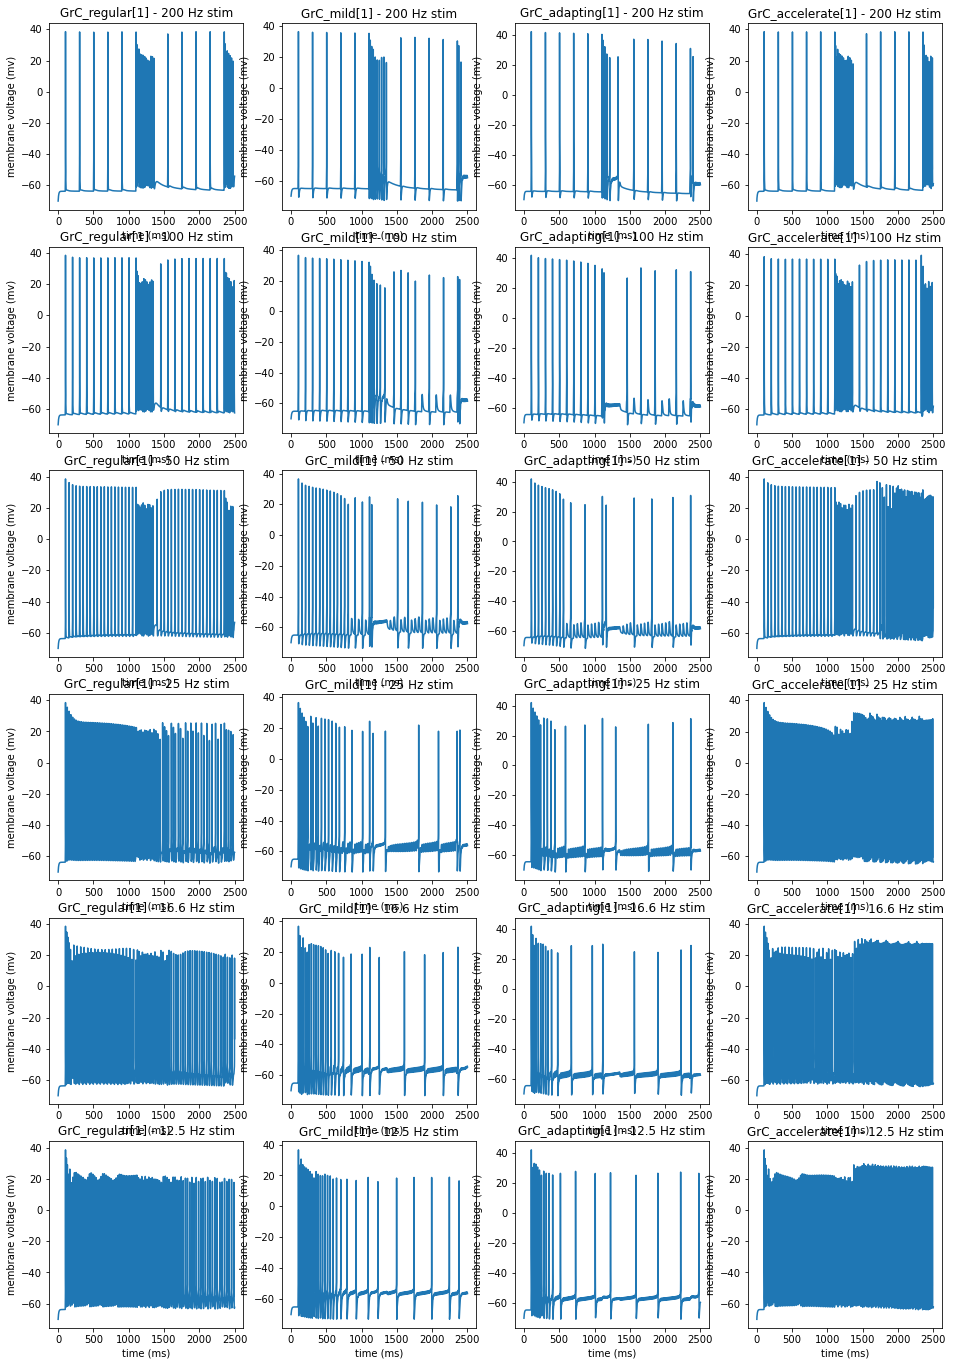

In [ ]:
########## Synaptic Background ##########
h.dt = 0.025
h.celsius = 32
h.tstop = 2000
h.v_init = -65

def create_stim(start=0, frequency=10, number=None, duration=1000, noise=0):
    stim = h.NetStim()
    stim.interval = frequency
    stim.number = duration//frequency if number is None else number
    stim.noise = noise
    stim.start = start
    return stim

frequencies = [200, 100, 50, 25, 16.6, 12.5]

plt.figure(figsize=(16, 24))
for j, cell in enumerate(cells):
    # number of AMPA syn, NMDA syn, dend number from 0 to 3
    cell.createsyn(1, 1, [0, 1], [0, 1])

    for i, frequency in enumerate(frequencies):
        stims = [create_stim(100, frequency), create_stim(1100, 10, 25),
                 create_stim(1350, frequency), create_stim(2350, 10, 25)]
        spk_nc_mfsyn = []
        spk_nc_mfsyn_nmda = []
        for stim in stims:
            spk_nc_mfsyn.extend(h.NetCon(stim, syn.input, 0, 0.1, 1) for syn in cell.MF_GrC)
            spk_nc_mfsyn_nmda.extend(h.NetCon(stim, syn.input, 0, 0.1, 1) for syn in cell.MF_GrC_mossy)

        time = h.Vector()
        time.record(h._ref_t)

        h.finitialize()
        h.run()

        plt.subplot(len(frequencies), len(cells), i*len(cells) + j + 1)
        plt.title(f"{repr(cell)} - {frequency} Hz stim")
        plt.plot(np.array(time), np.array(cell.vm_soma))
        plt.xlabel("time (ms)")
        plt.ylabel("membrane voltage (mv)")

        del stim, stims, spk_nc_mfsyn, spk_nc_mfsyn_nmda  # make sure these are all disconnected
